First download the ESC-50 dataset from https://github.com/karodvl/ESC-50/archive/master.zip. To make the dataset smaller, we can just use some of the wav files. In this notebook, the train folder contains x-*-0.wav to x-*-4.wav, where x = 1, 2, 3, 120 files in total; the validation folder contains 4-*-0.wav to 4-*-4.wav, 40 files in total; the test folder contains 5-*-0.wav to 5-*-4.wav, 40 files in total.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Try to play the audio in the notebook.

In [ ]:
import IPython.display as display

workspace_path = './drive/MyDrive/esc_50_sample'
train_data_path = workspace_path + '/train/'
val_data_path = workspace_path + '/val/'
test_data_path = workspace_path + '/test/'

display.Audio(train_data_path + '/1-100032-A-0.wav')

Check the number of wavs in each category:

In [ ]:
import glob
from collections import Counter

esc50_list = [f.split("-")[-1].replace(".wav", "") 
    for f in 
    glob.glob(train_data_path + '/*wav')]

Counter(esc50_list)

Counter({'0': 24, '1': 24, '2': 24, '3': 24, '4': 24})

Now designing a dataset class and create the dataloader.

In [ ]:
# this is not installed in Colab by default
# note some of the code below depends on 0.7.0 version
!pip install torchaudio==0.7.0

In [ ]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torchaudio

class ESC50(Dataset):
    def __init__(self, path):
        files = Path(path).glob('*.wav')
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", ""))) 
            for f in files]
        self.length = len(self.items)
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = torchaudio.load(filename)
        return audio_tensor, label

    def __len__(self):
        return self.length

train_esc50_data = ESC50(train_data_path)
tensor, label = list(train_esc50_data)[0]
print(tensor)
print(label) 

val_esc50_data = ESC50(val_data_path)
test_esc50_data = ESC50(test_data_path)

# create the dataloader
batch_size = 64
train_esc50_data_loader = DataLoader(train_esc50_data, 
    batch_size = batch_size, shuffle = True)
val_esc50_data_loader = DataLoader(val_esc50_data, 
    batch_size = batch_size, shuffle = True)
test_esc50_data_loader = DataLoader(test_esc50_data, 
    batch_size = batch_size, shuffle = True)

tensor([[-0.0085, -0.0094, -0.0081,  ...,  0.0000,  0.0000,  0.0000]])
1


Now we can define a CNN model. This model is said to be borrowed from https://arxiv.org/pdf/1610.00087.pdf.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        # note the layers are mostly 1d here
        self.conv1 = nn.Conv1d(100, 128, 5, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)
    
    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

my_model = AudioNet()
my_model.to(device)


AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

We are going to skip the lr finding part, as we have done it previously. Repeating it hardly provide any new knowledge gain. Then we are going to train the model.

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(my_model.parameters(), lr = 1e-2)

def loss_update(model, batch, loss_fn, device, check_result):
    inputs, targets = batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    output = model(inputs)
    loss = loss_fn(output, targets)
    num_current_correct = 0
    if (check_result):
        result = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_current_correct = torch.sum(result).item()
    return loss, num_current_correct

def train(model, optimizer, loss_fn, train_data_loader, val_data_loader, epochs, device):
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    # this is to set model in training mode
    model.train()
    check_result = False
    # training process
    for batch in train_data_loader:
      optimizer.zero_grad()
      loss = loss_update(model, batch, loss_fn, device, check_result)[0]
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item() * batch[0].shape[0]
    training_loss /= len(train_data_loader.dataset)

    # this is to set model in evaluation mode
    model.eval()
    check_result = True
    num_correct = 0
    num_examples = 0
    for batch in val_data_loader:
      loss, num_current_correct= loss_update(model, batch, loss_fn, device, check_result)
      valid_loss += loss.data.item() * batch[0].shape[0]
      num_correct += num_current_correct
      num_examples += batch[0].shape[0]
    valid_loss /= len(val_data_loader.dataset)

    print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

# modify the number of epochs to check how loss and accuracy changes with more training
# note this model needs a few more epochs to learn
train(my_model, optimizer, torch.nn.CrossEntropyLoss(), train_esc50_data_loader, val_esc50_data_loader, 20, device)

Epoch: 0, Training Loss: 2.55, Validation Loss: 33.28, accuracy = 0.12
Epoch: 1, Training Loss: 1.56, Validation Loss: 23.43, accuracy = 0.25
Epoch: 2, Training Loss: 1.09, Validation Loss: 9.13, accuracy = 0.20
Epoch: 3, Training Loss: 0.93, Validation Loss: 9.47, accuracy = 0.20
Epoch: 4, Training Loss: 0.66, Validation Loss: 3.74, accuracy = 0.33
Epoch: 5, Training Loss: 0.53, Validation Loss: 10.18, accuracy = 0.30
Epoch: 6, Training Loss: 0.38, Validation Loss: 6.03, accuracy = 0.25
Epoch: 7, Training Loss: 0.29, Validation Loss: 5.86, accuracy = 0.30
Epoch: 8, Training Loss: 0.26, Validation Loss: 5.92, accuracy = 0.28
Epoch: 9, Training Loss: 0.17, Validation Loss: 2.87, accuracy = 0.35
Epoch: 10, Training Loss: 0.22, Validation Loss: 2.34, accuracy = 0.50
Epoch: 11, Training Loss: 0.09, Validation Loss: 2.80, accuracy = 0.35
Epoch: 12, Training Loss: 0.10, Validation Loss: 2.57, accuracy = 0.47
Epoch: 13, Training Loss: 0.07, Validation Loss: 2.38, accuracy = 0.55
Epoch: 14, Tr

Mel Spectrograms is a way of displaying the frequency domain of a sound. We can plot the Mel Spectrograms of a sound using LibROSA, a python library for audio analysis.

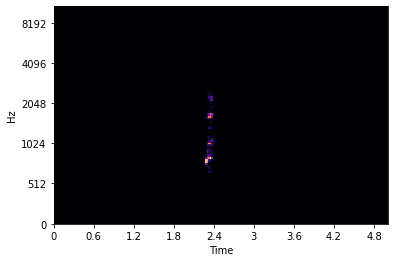

In [ ]:
import librosa
import librosa.display

sample_data, sample_rate = librosa.load(train_data_path + "/1-100032-A-0.wav")
spectrogram = librosa.feature.melspectrogram(sample_data, sample_rate)
librosa.display.specshow(spectrogram, sr = sample_rate, x_axis = 'time', y_axis = 'mel')

In [ ]:
We can also plot the above spectrogram in log scale, which is a common processing method in audio processing.

[[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]]


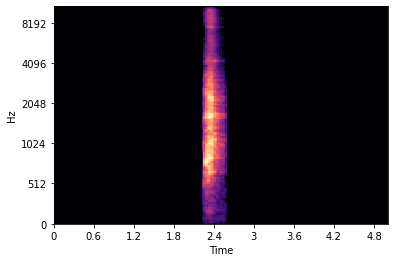

In [ ]:
import numpy as np
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
print(log_spectrogram)
librosa.display.specshow(log_spectrogram, sr = sample_rate, x_axis = 'time', y_axis = 'mel')

Now we are going to build a new dataset using the spectrograms.

In [ ]:
import torchvision
import matplotlib.pyplot as plt

class ESC50V2(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", "")))
            for f in files]
        self.length = len(self.items)
        self.transforms = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor()])
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = librosa.load(filename)
        spectrogram = librosa.feature.melspectrogram(sample_data, sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
        librosa.display.specshow(log_spectrogram, sr = sample_rate, x_axis = 'time', y_axis = 'mel')
        # this is to convert the figure into RGB data
        fig = plt.gcf().canvas
        fig.draw()
        audio_data = np.frombuffer(fig.tostring_rgb(), dtype = np.uint8)
        audio_data = audio_data.reshape(fig.get_width_height()[ : : -1] + (3, ))
        return (self.transforms(audio_data), label)
    def __len__(self):
        return self.length

train_esc50_data_v2 = ESC50V2(train_data_path)

Now we are going to profile the time of getting one index from the new dataset.

train_esc50_data indexing time
profiler time = 0.004629217000001518
train_esc50_data_v2 indexing time
profiler time = 0.4429813180000792


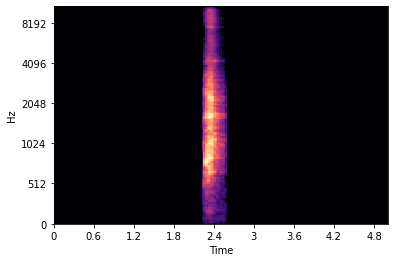

In [ ]:
import time

def profileDataset(dataset_class):
    start_time = time.process_time()
    dataset_class.__getitem__(1)
    end_time = time.process_time()
    print("profiler time = " + str(end_time - start_time))

print("train_esc50_data indexing time")
profileDataset(train_esc50_data)

print("train_esc50_data_v2 indexing time")
profileDataset(train_esc50_data_v2)


Using LRU (search LRU for more info) to save time:

In [ ]:
import functools
class ESC50V3(Dataset):
    def __init__(self, path):
        files = Path(path).glob("*.wav")
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", "")))
            for f in files]
        self.length = len(self.items)
        self.transforms = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor()])
    @functools.lru_cache(maxsize = 200)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audio_tensor, sample_rate = librosa.load(filename)
        spectrogram = librosa.feature.melspectrogram(sample_data, sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
        librosa.display.specshow(log_spectrogram, sr = sample_rate, x_axis = 'time', y_axis = 'mel')
        # this is to convert the figure into RGB data
        fig = plt.gcf().canvas
        fig.draw()
        audio_data = np.frombuffer(fig.tostring_rgb(), dtype = np.uint8)
        audio_data = audio_data.reshape(fig.get_width_height()[ : : -1] + (3, ))
        return (self.transforms(audio_data), label)
    def __len__(self):
        return self.length

train_esc50_data_v3 = ESC50V3(train_data_path)

train_esc50_data_v3 indexing time
profiler time = 0.411374439000042


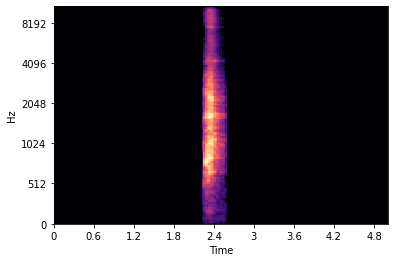

In [ ]:
# run this for multiple times to see the time saving brought by cache
print("train_esc50_data_v3 indexing time")
profileDataset(train_esc50_data_v3)

A better way is to do the sound to image processing first, as can be seen in the following.

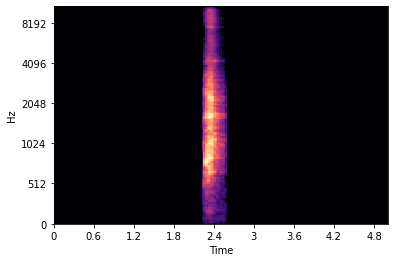

In [ ]:
def precompute_spectrograms(path):
    dpi = 50
    files = Path(path).glob("*.wav")
    for filename in files:
        audio_tensor, sample_rate = librosa.load(filename)
        spectrogram = librosa.feature.melspectrogram(sample_data, sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
        librosa.display.specshow(log_spectrogram, sr = sample_rate, x_axis = 'time', y_axis = 'mel')
        # save the figure
        plt.gcf().savefig("{}/img/{}_{}.png".format(
            filename.parent, dpi, filename.name), dpi = dpi)

# to store the images separately, mkdir folders like train/img, val/img, test/img
# under workspace
precompute_spectrograms(train_data_path)
precompute_spectrograms(val_data_path)
precompute_spectrograms(test_data_path)

Then we can define the new dataset based on the images converted from sound files.

In [ ]:
train_data_img_path = train_data_path + "/img"
val_data_img_path = val_data_path + "/img"
test_data_img_path = test_data_path + "/img"

from PIL import Image

class ESC50Img(Dataset):
    def __init__(self, path):
        self.dpi = 50
        files = Path(path).glob("{}*.wav.png".format(self.dpi))
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav.png", ""))) 
            for f in files]
        self.length = len(self.items)
        self.transforms = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(),
             torchvision.transforms.Normalize(
                 mean = [0.485, 0.456, 0.406],
                 std = [0.229, 0.224, 0.225])])
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.transforms(img), label)
    def __len__(self):
        return self.length

train_esc50_img_data = ESC50Img(train_data_img_path)
val_esc50_img_data = ESC50Img(val_data_img_path)
test_esc50_img_data = ESC50Img(test_data_img_path)

train_esc50_img_data_loader = DataLoader(
    train_esc50_img_data, batch_size = batch_size, shuffle = True)
val_esc50_img_data_loader = DataLoader(
    val_esc50_img_data, batch_size = batch_size, shuffle = True)
test_esc50_img_data_loader = DataLoader(
    test_esc50_img_data, batch_size = batch_size, shuffle = True)

In [ ]:
print("train_esc50_img_data indexing time")
profileDataset(train_esc50_img_data)

train_esc50_img_data indexing time
profiler time = 0.004991356999994423


Then we are going to fine tune a ResNet model to train the images converted from sound files. Much of the following is quite similar to that in the image processing.

In [ ]:
from torchvision import models
import copy
transfer_model = models.resnet50(pretrained = True)
my_model = copy.deepcopy(transfer_model)

# customizing the fc
my_model.fc = nn.Sequential(nn.Linear(my_model.fc.in_features, 500), 
                            nn.ReLU(),
                            nn.Linear(500, 50))
my_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We skip the lr finding process. Setting the lr for this model:

In [ ]:
import torch.optim as optim
# the better way to handle this is to set differential lr for each layer
optimizer = optim.Adam(my_model.parameters(), lr = 1e-4)
train(my_model, optimizer, torch.nn.CrossEntropyLoss(), 
      train_esc50_img_data_loader, val_esc50_img_data_loader, 20, device)

Epoch: 0, Training Loss: 3.85, Validation Loss: 3.76, accuracy = 0.20
Epoch: 1, Training Loss: 3.45, Validation Loss: 3.45, accuracy = 0.20
Epoch: 2, Training Loss: 3.13, Validation Loss: 3.14, accuracy = 0.20
Epoch: 3, Training Loss: 2.85, Validation Loss: 2.82, accuracy = 0.20
Epoch: 4, Training Loss: 2.58, Validation Loss: 2.51, accuracy = 0.20
Epoch: 5, Training Loss: 2.35, Validation Loss: 2.25, accuracy = 0.20
Epoch: 6, Training Loss: 2.15, Validation Loss: 2.03, accuracy = 0.20
Epoch: 7, Training Loss: 1.99, Validation Loss: 1.88, accuracy = 0.20
Epoch: 8, Training Loss: 1.87, Validation Loss: 1.78, accuracy = 0.20
Epoch: 9, Training Loss: 1.79, Validation Loss: 1.72, accuracy = 0.20
Epoch: 10, Training Loss: 1.73, Validation Loss: 1.68, accuracy = 0.20
Epoch: 11, Training Loss: 1.69, Validation Loss: 1.66, accuracy = 0.20
Epoch: 12, Training Loss: 1.67, Validation Loss: 1.65, accuracy = 0.20
Epoch: 13, Training Loss: 1.65, Validation Loss: 1.64, accuracy = 0.20
Epoch: 14, Train

In the following we are going to demonstrate a few ways of data augmentation in sound processing. To save time we are not going to apply them in the real training experiment ^_^.

In [ ]:
import torchaudio
# trimming using torchaudio
audio_tensor, _ = torchaudio.load(train_data_path + "/1-100032-A-0.wav")
print(audio_tensor.shape)
# the following are no longer supported in the new version of torchaudio
# besides, they are not a really useful data augmentation method
# trimmed_tensor = torchaudio.transforms.PadTrim(max_len = 1000)(audio_tensor)
# print(trimmed_tensor.shape)

torch.Size([1, 220500])


AttributeError: ignored

In [ ]:
# sox effect chains would apply various effects to the audio.

E = torchaudio.sox_effects.SoxEffectsChain()
# pitch chanage
E.append_effect_to_chain("pitch", [0.5])
E.set_input_file(train_data_path + "/1-100032-A-0.wav")
audio_tensor, sample_rate = E.sox_build_flow_effects()
display.Audio(audio_tensor.numpy(), rate = sample_rate)

/usr/local/lib/python3.7/dist-packages/torchaudio/sox_effects/sox_effects.py:343: UserWarning: torchaudio.sox_effects.SoxEffectsChain has been deprecated and will be removed from 0.8.0 release. Please migrate to `apply_effects_file` or `apply_effects_tensor`.
  'torchaudio.sox_effects.SoxEffectsChain has been deprecated and '
/usr/local/lib/python3.7/dist-packages/torchaudio/sox_effects/sox_effects.py:368: UserWarning: torchaudio.sox_effects.sox_effects.SoxEffect has been deprecated and will be removed from 0.8.0 release. Please migrate to `apply_effects_file` or `apply_effects_tensor`.
  e = SoxEffect()


Frequency masking and time masking are two advanced ways of sound data augmentation, as published in Google's paper https://arxiv.org/abs/1904.08779. We are going to define a data transformer of frequency and time masking. Note the processing is still done on the image converted from sound.

In [ ]:
import random

# frequency masking
class FrequencyMask():
    def __init__(self, max_width):
        self.max_width = max_width
    # x is an image tensor
    # by default, PIL image to torch tensor has format C, H, W
    def __call__(self, x):
        start = random.randrange(0, x.shape[2])
        end = start + random.randrange(1, self.max_width)
        # setting frequency to mean
        x[:, start : end, :] = x.mean()
        return x
    def __repr__(self):
        return "FrequencyMask class"

# time masking
class TimeMask():
    def __init__(self, max_width):
        self.max_width = max_width
    # x is an image tensor
    def __call__(self, x):
        start = random.randrange(0, x.shape[1])
        end = start + random.randrange(1, self.max_width)
        # setting frequency to mean
        x[:, start : end, :] = 0
        return x
    def __repr__(self):
        return "TimeMask class"

orginal img


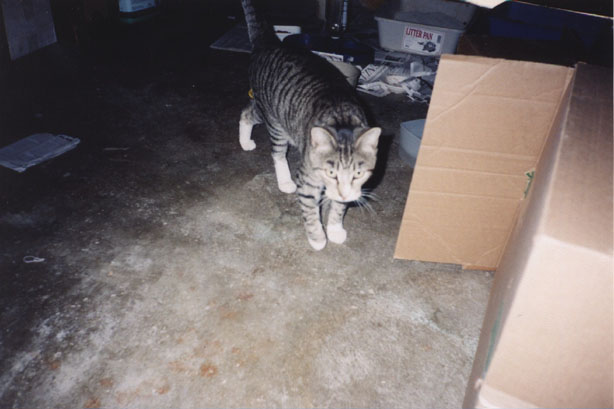

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("./drive/MyDrive/image_classification_test/train/cat/TigerCat.JPG")
my_transform_to_tensor =  torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor()])
my_transform_to_image =  torchvision.transforms.Compose(
            [torchvision.transforms.ToPILImage()])
transformed_tensor = my_transform_to_tensor(img)

print("orginal img")
display(img)

frequency masking img


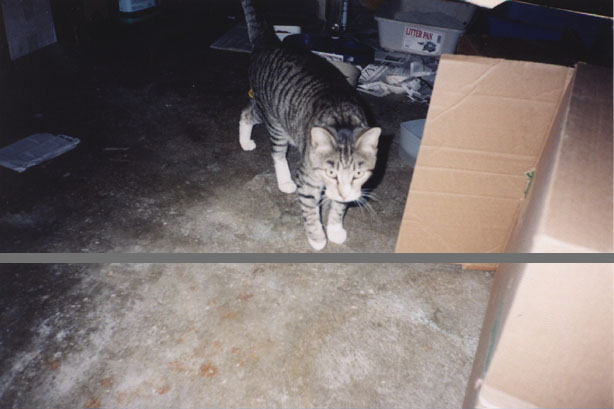

In [ ]:
my_transform_fm = torchvision.transforms.Compose(
    [torchvision.transforms.RandomApply([FrequencyMask(40)], p = 1.0)])

transformed_tensor_fm = my_transform_fm(transformed_tensor)
print("frequency masking img")
display(my_transform_to_image(transformed_tensor_fm))

time masking img


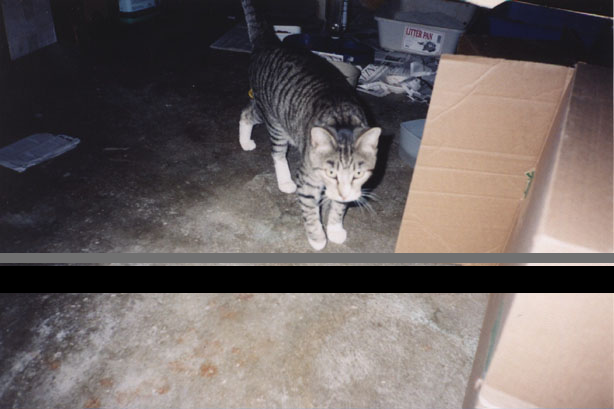

In [ ]:
my_transform_tm = torchvision.transforms.Compose(
    [torchvision.transforms.RandomApply([TimeMask(40)], p = 1.0)])

transformed_tensor_tm = my_transform_tm(transformed_tensor)
print("time masking img")
display(my_transform_to_image(transformed_tensor_tm))